# 4. Semantic Space Construction

In this NB, I will apply the new `heads` edge feature to extract head nouns from their phrase and record their co-occurring verbs, subjects, objects, and coordinates. Each of these relationships is assigned a weight. Those co-occurrences are then placed into a matrix. Then I assign an associational measure to the counts

In [52]:
import collections, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tf.fabric import Fabric
from scipy.cluster.hierarchy import linkage, dendrogram


TF = Fabric(locations='~/github', modules=['etcbc/bhsa/tf/c', 'semantics/tf/c'])
api = TF.load('''
                book chapter verse
                function lex vs language
                pdp freq_lex gloss domain
                voc_lex_utf8
                heads
              ''')
api.makeAvailableIn(globals())

This is Text-Fabric 3.2.2
Api reference : https://github.com/Dans-labs/text-fabric/wiki/Api
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

116 features found and 0 ignored
  0.00s loading features ...
   |     0.01s B book                 from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.00s B chapter              from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B verse                from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.07s B function             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.13s B lex                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.13s B vs                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.15s B language             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.15s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.11s B freq_lex             from /Users/cody/github/etcbc/bh

## Gather and Count Noun Relations

Now I will gather nouns from the Hebrew Bible and count syntactic co-occurrences.

In [395]:
# configure weights
path_weights = {'Subj': {'Pred': 1,
                         'Objc': 1
                        },
                'Objc': {
                         'Pred': 1,
                         'Subj': 1
                        },
                'coor': 1
               }

In [396]:
cooccurrences = collections.defaultdict(lambda: collections.Counter()) # noun counts here

# Subj/Objc Counts
for phrase in F.otype.s('phrase'):
    
    # skip non-Hebrew sections
    language = F.language.v(L.d(phrase, 'word')[0]) 
    if language != 'Hebrew':
        continue
    
    # skip non subject/object phrases
    function = F.function.v(phrase)
    if function not in {'Subj', 'Objc'}:
        continue
    
    # get head nouns
    nouns = set(F.lex.v(w) for w in E.heads.f(phrase)) # count lexemes only once
    if not nouns:
        continue
    
    # restrict on frequency
    freq = [F.freq_lex.v(L.u(w, 'lex')[0]) for w in E.heads.f(phrase)]
    if min(freq) < 10:
        continue

    # restrict on proper names
    types = set(F.pdp.v(w) for w in E.heads.f(phrase))
    if {'nmpr'} & types:
        continue

    # restrict on domain
    if F.domain.v(L.u(phrase, 'clause')[0]) != 'N':
        continue
    
    # gather contextual data
    clause = L.u(phrase, 'clause')[0]
    good_paths = path_weights[function]
    paths = [phrase for phrase in L.d(clause, 'phrase')
                if F.function.v(phrase) in good_paths.keys()
            ]
    
    # make the counts
    for path in paths:
        
        pfunct = F.function.v(path)
        weight = good_paths[pfunct]
        
        # count for verb
        if pfunct == 'Pred':
            verb = [w for w in L.d(path, 'word') if F.pdp.v(w) == 'verb'][0]
            verb_lex = F.lex.v(verb)
            verb_stem = F.vs.v(verb)
            verb_basis = function + '.' + verb_lex + '.' + verb_stem # with function name added
            if verb and F.lex.v(verb) not in {'HJH['}: # omit "to be" verbs, others?
                for noun in nouns:
                    cooccurrences[noun][verb_basis] += 1
        
        # count for subj/obj
        else:
            conouns = E.heads.f(path)
            cnoun_bases = set(function + '.' + F.lex.v(w) + f'.{pfunct}' for w in conouns) # with function name added
            counts = dict((basis, weight) for basis in cnoun_bases)
            if counts:
                for noun in nouns:
                    cooccurrences[noun].update(counts)
    
    # count coordinates
    for noun in nouns:
        for cnoun in nouns:
            if cnoun != noun:
                cnoun_basis = 'coor.'+cnoun # with coordinate function name
                cooccurrences[noun][cnoun_basis] += path_weights['coor']
                
# weed out results with little data
cooccurrences = dict((word, counts) for word, counts in cooccurrences.items()
                        if sum(counts.values()) >= 10
                    )
                
cooccurrences = pd.DataFrame(cooccurrences).fillna(0)                

print(len(cooccurrences.columns), 'nouns')
print(len(cooccurrences.index), 'cooccurrences')

202 nouns
1546 cooccurrences


## Apply Association Measure

In [397]:
def safe_log(number):
    '''
    Evaluate for zero before applying log function.
    '''
    if number == 0:
        return 0
    else:
        return math.log(number)
    
def loglikelihood(k, l, m, n, log):
    '''
    Returns the log-likelihood when the supplied elements are given.
    '''
    
    p1 = (k*log(k)) + (l*log(l)) + (m*log(m)) + (n*log(n))        
    p2 = ((k+l)*log(k+l)) - ((k+m)*log(k+m))
    p3 = ((l+n)*log(l+n)) - ((m+n)*log(m+n))
    p4 = ((k+l+m+n))*log(k+l+m+n)
    llikelihood = 2*(p1-p2-p3+p4)
    return llikelihood

def apply_loglikelihood(comatrix):
    
    '''
    Adjusts values in a cooccurrence matrix using log-likelihood. 
    Requires a cooccurrence matrix.
    '''
    new_matrix = comatrix.copy()
    i = 0 
    indent(reset=True)
    info('beginning calculations...')
    indent(1, reset=True)
    for target in comatrix.columns:
        for basis in comatrix.index:
            k = comatrix[target][basis]
            
            if not k:
                i += 1
                if i % 500000 == 0:
                    indent(1)
                    info(f'at iteration {i}')
                continue
            
            l = comatrix.loc[basis].sum() - k
            m = comatrix[target].sum() - k
            n = comatrix.values.sum() - (k+l+m)
            ll = loglikelihood(k, l, m, n, safe_log)
            new_matrix[target][basis] = ll

            i += 1
            if i % 500000 == 0:
                indent(1)
                info(f'at iteration {i}')
    indent(0)
    info(f'FINISHED at iteration {i}')
    return new_matrix

In [398]:
test_ll = apply_loglikelihood(cooccurrences) / 10000 # division to make numbers more managable

  0.00s beginning calculations...
  5.57s FINISHED at iteration 312292


## PMI
Pointwise Mutual Information Scores

In [399]:
def apply_pmi(col):
    
    '''
    Apply PMI to a given column.
    '''
    
    expected = col * cooccurrences.sum(axis=1) / cooccurrences.values.sum()
    pmi = np.log(col / expected).fillna(0)
    
    return pmi

test_pmi = cooccurrences.apply(lambda k: apply_pmi(k))
os.system('say "The PMI is ready for analysis!"')

0

## Data Exploration

In [400]:
def get_lex(lex_string):
    '''
    Return ETCBC lex node from a string.
    '''
    lex = next(lex for lex in F.otype.s('lex') if F.lex.v(lex) == lex_string)
    
    return lex

pca = PCA(n_components=2)

def show_dependency(test_matrix, pca_vectors, boolean_req, invert=False):
    
    # get X and Y counts
    x = pd.Series(list(r[0] for r in pca_vectors)) # x-axes in the semantic space
    y = test_matrix[boolean_req].sum().values / test_matrix.sum().values # count subject roles


    # prepare a trendline
    fit = np.polyfit(x, y, deg=1)
    p = np.poly1d(fit)

    # assemble DF for plotting
    x_rela = pd.DataFrame(x, columns=['X'])
    x_rela[rela_string] = y
    x_rela['trendline'] = p(x_rela.loc[:, 'X'])

    #plot
    ax = x_rela.plot.scatter(x='X', y=rela_string, figsize=(10, 8))
    x_rela.set_index('X', inplace=True)
    x_rela.trendline.sort_index(ascending=True).plot(ax=ax)

    if invert:
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    
    # annotate
    words = [F.gloss.v(get_lex(l)) for l in test_matrix.columns]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(x[i], y[i]))

### Raw Counts

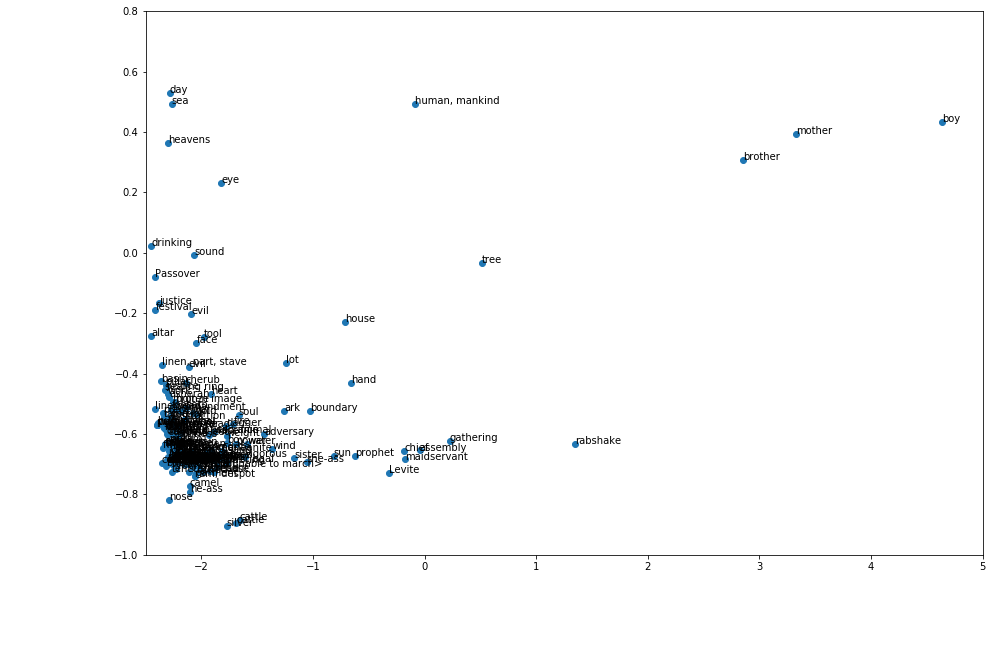

In [401]:
raw_result = pca.fit_transform(cooccurrences.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(raw_result[:, 0], raw_result[:, 1])

zoom = [-5, 25, -5, 5]
zoom1 = [-2.5, 5, -1, .8]
zoom2 = [-2.5, -1.3, -0.9, -0.25]
plt.axis(zoom1)

# annotate 
words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(raw_result[i, 0], raw_result[i, 1]))

In [402]:
print(cooccurrences['XRB/'][test_pmi['XRB/'] != 0].sort_values(ascending=False).head(20))
print()
print(cooccurrences['>C/'][test_pmi['>C/'] != 0].sort_values(ascending=False).head(20))



Objc.LQX[.qal     4.0
Subj.BW>[.qal     2.0
Objc.XGR[.qal     2.0
Objc.NTN[.qal     2.0
Objc.CLP[.qal     2.0
Objc.>JC/.Subj    2.0
Objc.<FH[.qal     2.0
Subj.>KL[.qal     1.0
Objc.N<R/.Subj    1.0
Objc.FJM[.qal     1.0
Objc.CWB[.hif     1.0
Objc.BW>[.hif     1.0
Name: XRB/, dtype: float64

Subj.JY>[.qal      4.0
Subj.B<R[.qal      3.0
Subj.>KL[.qal      2.0
Subj.JRD[.qal      2.0
Objc.JYT[.hif      2.0
Objc.NTN[.qal      2.0
Objc.HR/.Subj      1.0
Objc.JY>[.hif      1.0
Objc.QRB[.hif      1.0
Subj.<LH[.qal      1.0
coor.SWS/          1.0
coor.RKB/          1.0
Subj.BXWR/.Objc    1.0
Subj.CQ<[.qal      1.0
Subj.HLK[.qal      1.0
Subj.NFQ[.nif      1.0
Subj.NPL[.qal      1.0
Objc.B<R[.hif      1.0
Name: >C/, dtype: float64


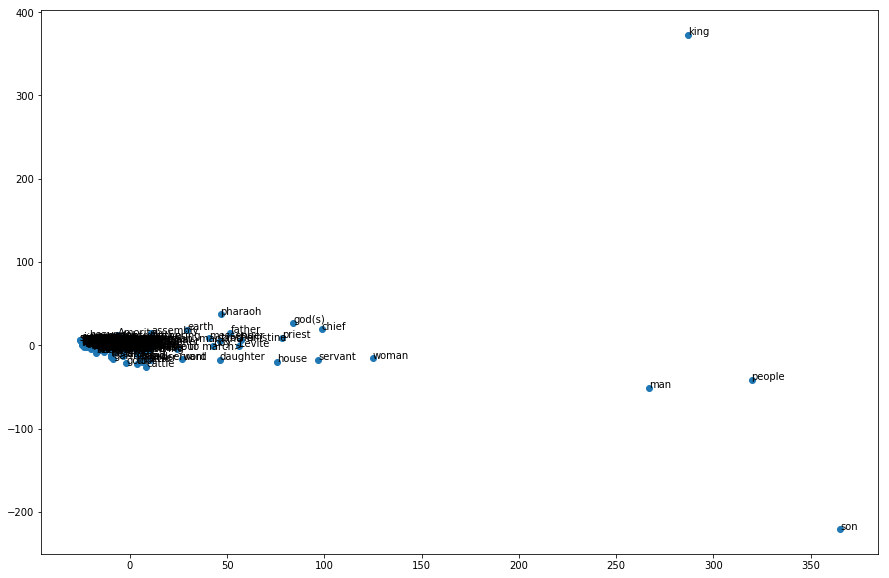

In [403]:
ll_result = pca.fit_transform(test_ll.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(ll_result[:, 0], ll_result[:, 1])

#plt.axis([-27, 70, -30, 50])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(ll_result[i, 0], ll_result[i, 1]))

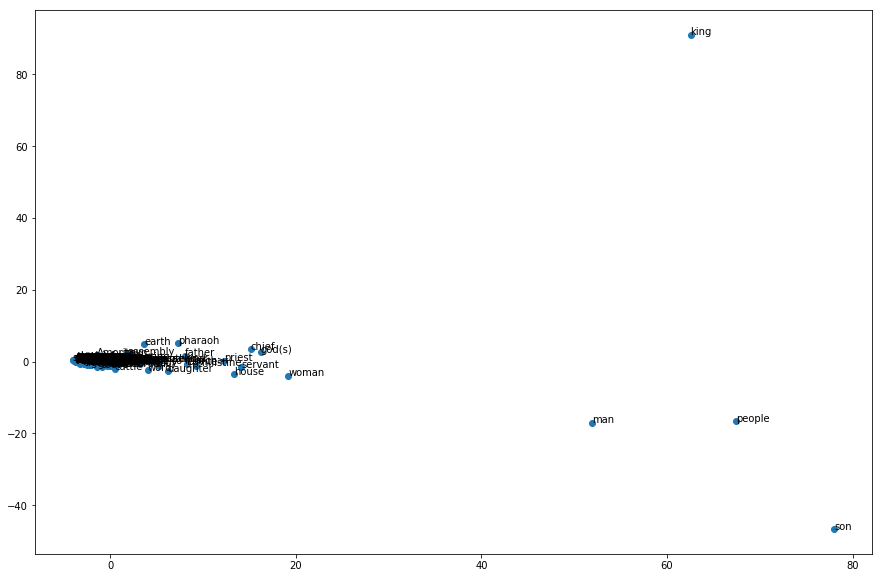

In [404]:
pmi_result = pca.fit_transform(test_pmi.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pmi_result[:, 0], pmi_result[:, 1])

cluster1 = [-5, 20, -10, 10]
cluster2 = [-0.8, 3, -1.25, 1.5]
[-6, 20, -3, 20]

#plt.axis([-1, 2, -3, 5])
#plt.axis([-6, 20, -5, 6])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_pmi.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pmi_result[i, 0], pmi_result[i, 1]))

## Data Exploration

### Is there a correlation between Subject frames and Semantic Space Clustering?

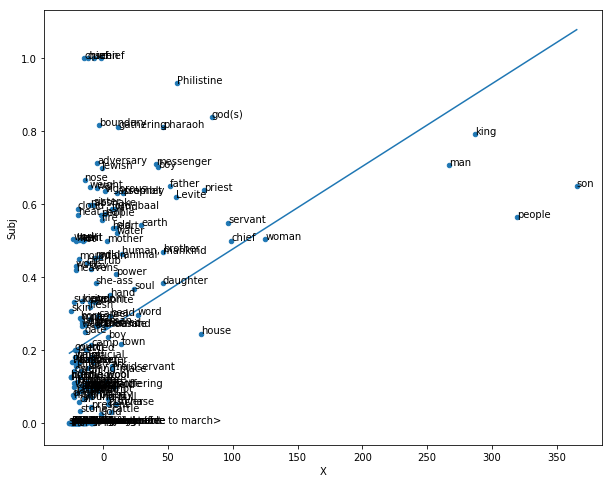

In [405]:
show_dependency(test_ll, ll_result, test_ll.index.str.startswith('Subj'))

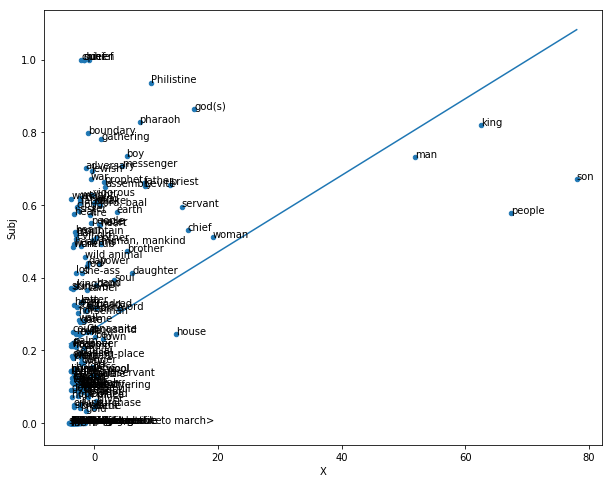

In [406]:
show_dependency(test_pmi, pmi_result, test_pmi.index.str.startswith('Subj'))

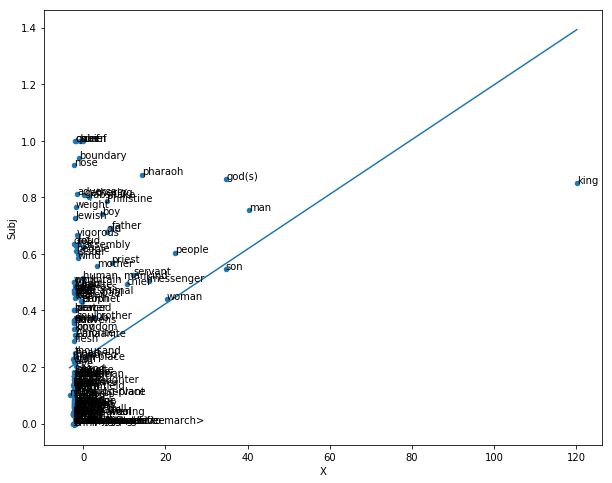

In [407]:
show_dependency(cooccurrences, raw_result, cooccurrences.index.str.startswith('Subj'))

### What if dependency is tested for acts associated with "man"?

Man Acts

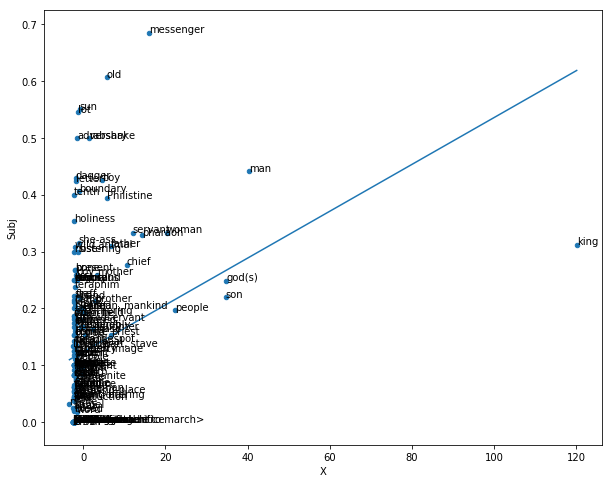

In [408]:
# Most common frames for "man"
man = cooccurrences['>JC/'][cooccurrences['>JC/'] != 0]
man_acts = set()

for act in man.sort_values(ascending=False).index[:20]:
    man_acts.add(act)

# MAN ACTS
show_dependency(cooccurrences, raw_result, cooccurrences.index.isin(man_acts))

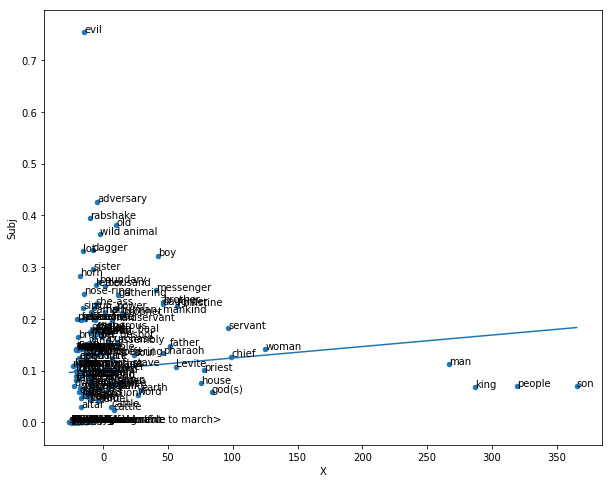

In [409]:
# MAN ACTS
show_dependency(test_ll, ll_result, test_ll.index.isin(man_acts))

Digging deeper into the similarity between "man", "people", "king", and "son"

In [410]:
man = test_pmi['>JC/'][test_pmi['>JC/'] != 0]
people = test_pmi['>M/'][test_pmi['>M/'] != 0]

man.sort_values(ascending=False).head(20)

Subj.NRGL/.Objc         9.105979
Subj.QBWRH/.Objc        9.105979
Subj.TMH[.qal           9.105979
Subj.SKWT_BNWT/.Objc    9.105979
Subj.>PRJM/.Objc        9.105979
Objc.CBV/.Subj          9.105979
Subj.MXRCT/.Objc        9.105979
Subj.MXRCH/.Objc        9.105979
Subj.>CJM>/.Objc        9.105979
Subj.XLH[.piel          9.105979
Subj.LQV[.hit           9.105979
Subj.>BQ[.nif           9.105979
Subj.QRDM/.Objc         9.105979
Subj.MWL[.nif           9.105979
Subj.MLXMH/.Objc        9.105979
Subj.MQWM/.Objc         9.105979
Subj.>T/.Objc           9.105979
Subj.>X/.Objc           9.105979
Subj.MR>H=/.Objc        9.105979
Subj.<YB[.hit           9.105979
Name: >JC/, dtype: float64

In [411]:
man = test_ll['>JC/'][test_ll['>JC/'] != 0]

man

Objc.<LH[.hif           33.414640
Objc.<NH[.qal           33.661339
Objc.>CH/.Subj          33.689240
Objc.>JC/.Subj          33.596835
Objc.>SP[.qal           33.612380
Objc.BDL[.nif           33.722136
Objc.BJT/.Subj          33.705501
Objc.BQC[.piel          33.681131
Objc.BW>[.hif           33.454850
Objc.BXR[.qal           33.709585
Objc.C>L[.qal           33.677079
Objc.C>R[.hif           33.668981
Objc.CBV/.Subj          33.722136
Objc.CLJC=/.Subj        33.718726
Objc.CLK[.hif           33.656842
Objc.CLX[.piel          33.632871
Objc.CLX[.qal           33.293310
Objc.CM<[.qal           33.475142
Objc.CS<[.piel          33.722136
Objc.FKR[.qal           33.713686
Objc.HRG[.qal           33.644710
Objc.JD<[.hif           33.713686
Objc.JD<[.qal           33.689538
Objc.JR>[.qal           33.701427
Objc.KLH[.piel          33.697360
Objc.LQX[.qal           32.942321
Objc.ML>[.qal           33.656842
Objc.MLK/.Subj          33.479176
Objc.MWT[.hif           33.705501
Objc.MY>[.qal 

### X Plotted aganst Object and Coordination

Now against the "object" frame...

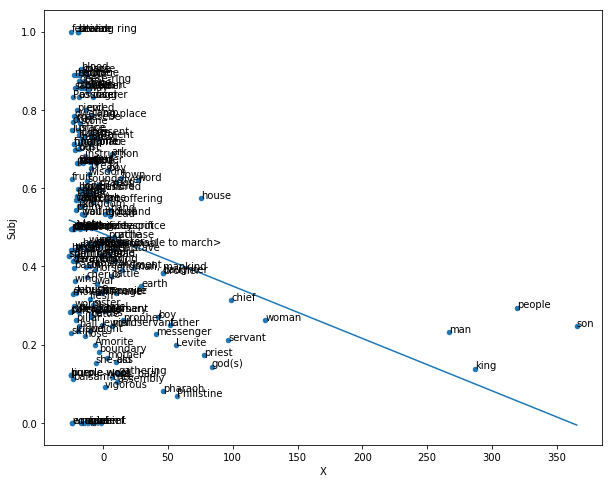

In [413]:
show_dependency(test_ll, ll_result, test_ll.index.str.startswith('Objc'))

And against "coordinate" relation with reversed axes.

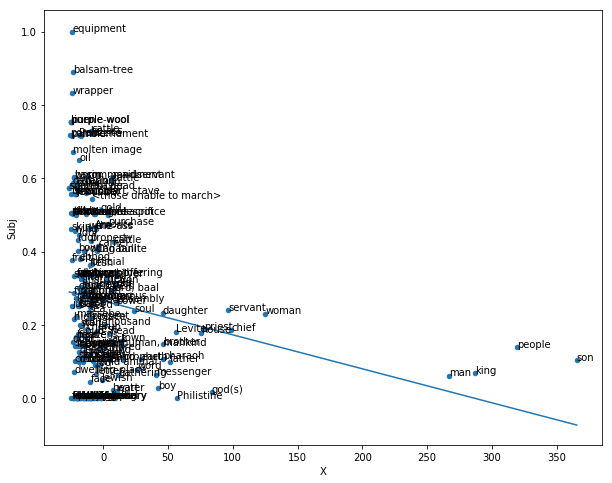

In [414]:
show_dependency(test_ll, ll_result, test_ll.index.str.startswith('coor'))

Agency is slightly favorable to a larger value on the X axis of the semantic space. But it doesn't appear to be a strong association. In most cases, the four nuns MLK/, >M/, BN/, and >JC/ appear to be the most unlike the rest of the nouns.

## Agentive Archetypes?

Can the nouns identified as "strong" agentive serve as reference points (ft. archetypes?) for other agentive words? 

1. Combine the vectors of king, son, man, god, woman, servant, chief, priest, and house.
2. Calculate other noun's similarity to the archetypal vector.
3. Extract those nouns with very small to no similarity with the reference vector and examine them to see whether we have obtained a list of archetypical *non-agentive* nouns.

In [ ]:
def cosine_sim(vectA, vectB):
    '''
    INCOMPLETE
    Calculate the similarity between a supplied vector A and vector B.
    '''
    new_matrix = comatrix.copy()
    i = 0 
    indent(reset=True)
    info('beginning calculations...')
    indent(1, reset=True)
    
    cos = sum(vectA * vectB) / (math.sqrt(sum(vectA*vectA)) * math.sqrt(sum(vectB*vectB)))
    
    for target in comatrix.columns:
        for basis in comatrix.index:
            pass

In [313]:
def show_sim(testw, test):    
    '''
    Return a comparison of similar words for a given test word.
    '''
    
    test_sims = []
    vectA = test[testw]

    for word in test.columns:

        if word  == testw:
            continue

        vectB = test[word]

        cosine = sum(vectA * vectB) / (math.sqrt(sum(vectA*vectA)) * math.sqrt(sum(vectB*vectB)))

        test_sims.append((cosine, word))

    results = []
        
    for score, word in sorted(test_sims, reverse=True)[:25]:

        lex = [lex for lex in F.otype.s('lex') if F.lex.v(lex) == word][0]

        results.append([score, word, F.gloss.v(lex), F.freq_lex.v(lex)])
        
    return(results)

In [315]:
show_sim('>JC/', test_ll)

[[0.3632005501525337, '<M/', 'people', 1866],
 [0.3388102726930351, 'BN/', 'son', 4937],
 [0.3011705586571467, '<BD/', 'servant', 800],
 [0.28946366379249977, '>CH/', 'woman', 781],
 [0.26697192510485007, 'FR/', 'chief', 421],
 [0.2590232693294712, 'PLCTJ/', 'Philistine', 288],
 [0.24897081069196508, 'MLK/', 'king', 2523],
 [0.2451558178543049, 'N<R/', 'boy', 240],
 [0.22969838621195804, '>X/', 'brother', 629],
 [0.22729834331178705, 'ML>K/', 'messenger', 213],
 [0.22103560908580014, 'PR<H/', 'pharaoh', 274],
 [0.21568931550671228, 'KHN/', 'priest', 750],
 [0.20511958467829997, 'NBJ>/', 'prophet', 315],
 [0.19030945236709376, 'LWJ/', 'Levite', 292],
 [0.1883600830796714, '>B/', 'father', 1217],
 [0.18573206016045457, 'ZQN/', 'old', 181],
 [0.18164725909485788, 'NPC/', 'soul', 754],
 [0.1778279954377804, 'BT/', 'daughter', 588],
 [0.17425823803251378, 'BJT/', 'house', 2063],
 [0.1661025765658656, 'RB_CQH/', 'rabshake', 16],
 [0.16547927783189198, 'DBR/', 'word', 1441],
 [0.1644476973001

In [154]:
top_hits = []

for word in cooccurrences.columns:
    
    sim = show_sim(word, test_pmi)[0]
    
    sim.insert(0, word)
    
    top_hits.append(sim)
    
os.system(f'say "ready with {len(top_hits)} results"')

0

In [155]:
top_hits = sorted(top_hits, key=lambda k: k[1], reverse=True)
top_hits2 = [[F.gloss.v(get_lex(r[0]))] + r for r in top_hits]

top_hits2

[['commandment', 'MYWH/', 0.5522473215393914, 'TWRH/', 'instruction', 220],
 ['instruction', 'TWRH/', 0.5522473215393914, 'MYWH/', 'commandment', 181],
 ['silver', 'KSP/', 0.549998953939407, 'ZHB/', 'gold', 389],
 ['gold', 'ZHB/', 0.549998953939407, 'KSP/', 'silver', 403],
 ['asherah', '>CRH/', 0.4746088566364991, 'MYBH/', 'massebe', 32],
 ['massebe', 'MYBH/', 0.4746088566364991, '>CRH/', 'asherah', 40],
 ['final offer', 'CLM/', 0.4608865749663053, 'PR/', 'young bull', 133],
 ['young bull', 'PR/', 0.4608865749663053, 'CLM/', 'final offer', 87],
 ['cattle', 'BQR/', 0.46005009430536353, 'Y>N/', 'cattle', 274],
 ['cattle', 'Y>N/', 0.46005009430536353, 'BQR/', 'cattle', 183],
 ['Passover', 'PSX/', 0.45308605590367373, 'XG/', 'festival', 62],
 ['festival', 'XG/', 0.45308605590367373, 'PSX/', 'Passover', 49],
 ['justice', 'MCPV/', 0.43109865009890946, 'XQ/', 'portion', 129],
 ['portion', 'XQ/', 0.43109865009890946, 'MCPV/', 'justice', 422],
 ['altar', 'MZBX/', 0.41246939666935606, 'MYBH/', '

In [118]:
 ['plunder', 'CLL/', 0.36935158955138775, 'JJN/', 'wine', 141],


['blow', 'MGPH/', 0.2868550550832243, 'PRD/', 'mule', 14]

In [161]:
w1 = 'CLL/'
w2 = 'CLL/'
test = cooccurrences

test[test[w1] != 0][w1].sort_values(ascending=False)

Objc.BZZ[.qal     5.0
Objc.JY>[.hif     2.0
Objc.BW>[.hif     2.0
Objc.NF>[.qal     1.0
Objc.CLX[.piel    1.0
Objc.BN/.Subj     1.0
Name: CLL/, dtype: float64

In [162]:
test_pmi[test[w2] != 0][w2].sort_values(ascending=False)

Objc.BZZ[.qal     6.524736
Objc.CLX[.piel    5.691827
Objc.BN/.Subj     5.495117
Objc.JY>[.hif     5.271973
Objc.BW>[.hif     4.700187
Objc.NF>[.qal     4.273445
Name: CLL/, dtype: float64

In [100]:
cooccurrences[cooccurrences['KWS/'] != 0]['KWS/'].sort_values(ascending=False)

Objc.NTN[.qal    5.0
Objc.LQX[.qal    4.0
Objc.CTH[.qal    3.0
coor.GBJ</       1.0
Subj.SBB[.qal    1.0
Subj.<BR[.qal    1.0
Objc.NF>[.qal    1.0
Objc.CQH[.hif    1.0
Name: KWS/, dtype: float64